In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [28]:
#GET IMAGE DATASET
train_dataset_path = r'C:\Users\USER\Documents\Kuliah\CompVis\train'
validation_dataset_path = r'C:\Users\USER\Documents\Kuliah\CompVis\validation'

In [29]:
#APPLYING IMAGE AUGMENTATION
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 2697 images belonging to 4 classes.
Found 772 images belonging to 4 classes.


In [30]:
#LABEL MAPPINGS
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Duck
1 : Front
2 : Left Tilt
3 : Right Tilt


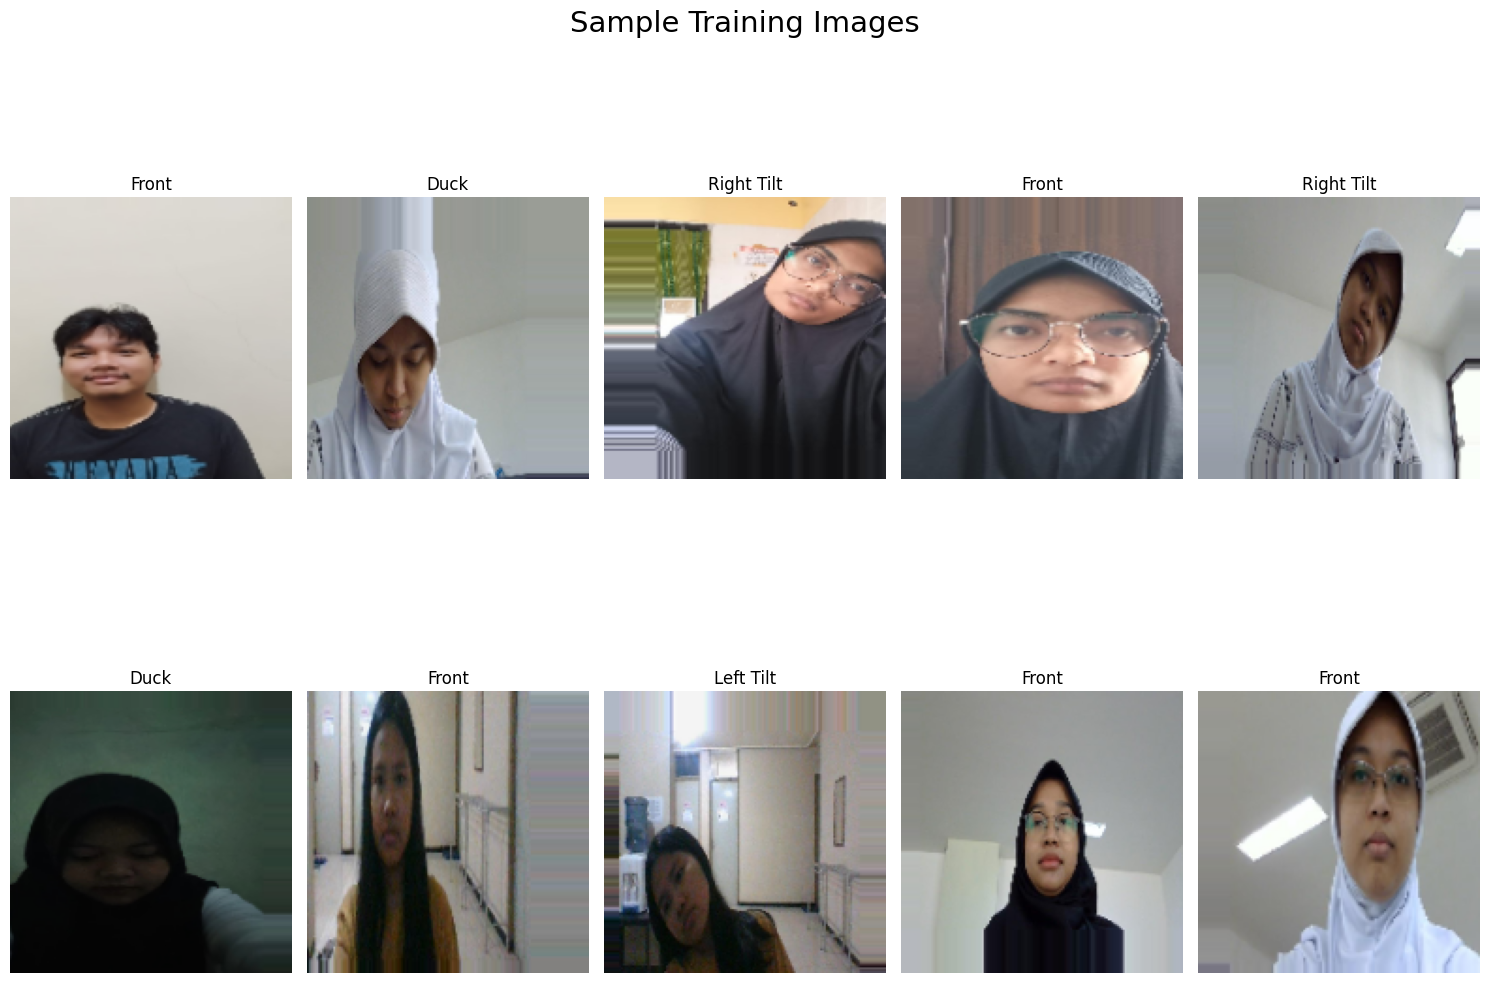

In [31]:
#Plotting Sample Training Images
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [34]:
#CREATE CNN MODEL
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=4, activation='softmax')
    ])
    
    return model

cnn_model = create_model()

print(cnn_model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 146, 146, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 146, 146, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 73, 73, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 71, 71, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 71, 71, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 35, 35, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 33, 33, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 33, 33, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,201,316 (8.40 MB)

 Trainable params: 2,200,868 (8.40 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [35]:
#Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [36]:
#Defining the Optimizer
optimizer = Adam(learning_rate=0.001)

In [37]:
#Compile the Model
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [38]:
# Training the Model with EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = cnn_model.fit(train_generator, epochs=100, validation_data=validation_generator,
                        verbose=2,
                        callbacks=[reduce_lr, early_stopping])

Epoch 1/100
85/85 - 60s - 707ms/step - accuracy: 0.4902 - loss: 2.1304 - val_accuracy: 0.2241 - val_loss: 3.0491 - learning_rate: 0.0010
Epoch 2/100
85/85 - 54s - 639ms/step - accuracy: 0.6455 - loss: 1.2161 - val_accuracy: 0.3187 - val_loss: 2.2899 - learning_rate: 0.0010
Epoch 3/100
85/85 - 54s - 634ms/step - accuracy: 0.6986 - loss: 0.9731 - val_accuracy: 0.4728 - val_loss: 2.1141 - learning_rate: 0.0010
Epoch 4/100
85/85 - 54s - 641ms/step - accuracy: 0.7464 - loss: 0.7377 - val_accuracy: 0.5104 - val_loss: 1.3114 - learning_rate: 0.0010
Epoch 5/100
85/85 - 57s - 671ms/step - accuracy: 0.7824 - loss: 0.6300 - val_accuracy: 0.6606 - val_loss: 1.1475 - learning_rate: 0.0010
Epoch 6/100
85/85 - 56s - 659ms/step - accuracy: 0.8161 - loss: 0.5378 - val_accuracy: 0.7150 - val_loss: 0.6655 - learning_rate: 0.0010
Epoch 7/100
85/85 - 57s - 671ms/step - accuracy: 0.8435 - loss: 0.4766 - val_accuracy: 0.9430 - val_loss: 0.2264 - learning_rate: 0.0010
Epoch 8/100
85/85 - 56s - 664ms/step - ac

In [39]:
#Plotting training and validation accuracy, loss and learning rate
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['learning_rate']

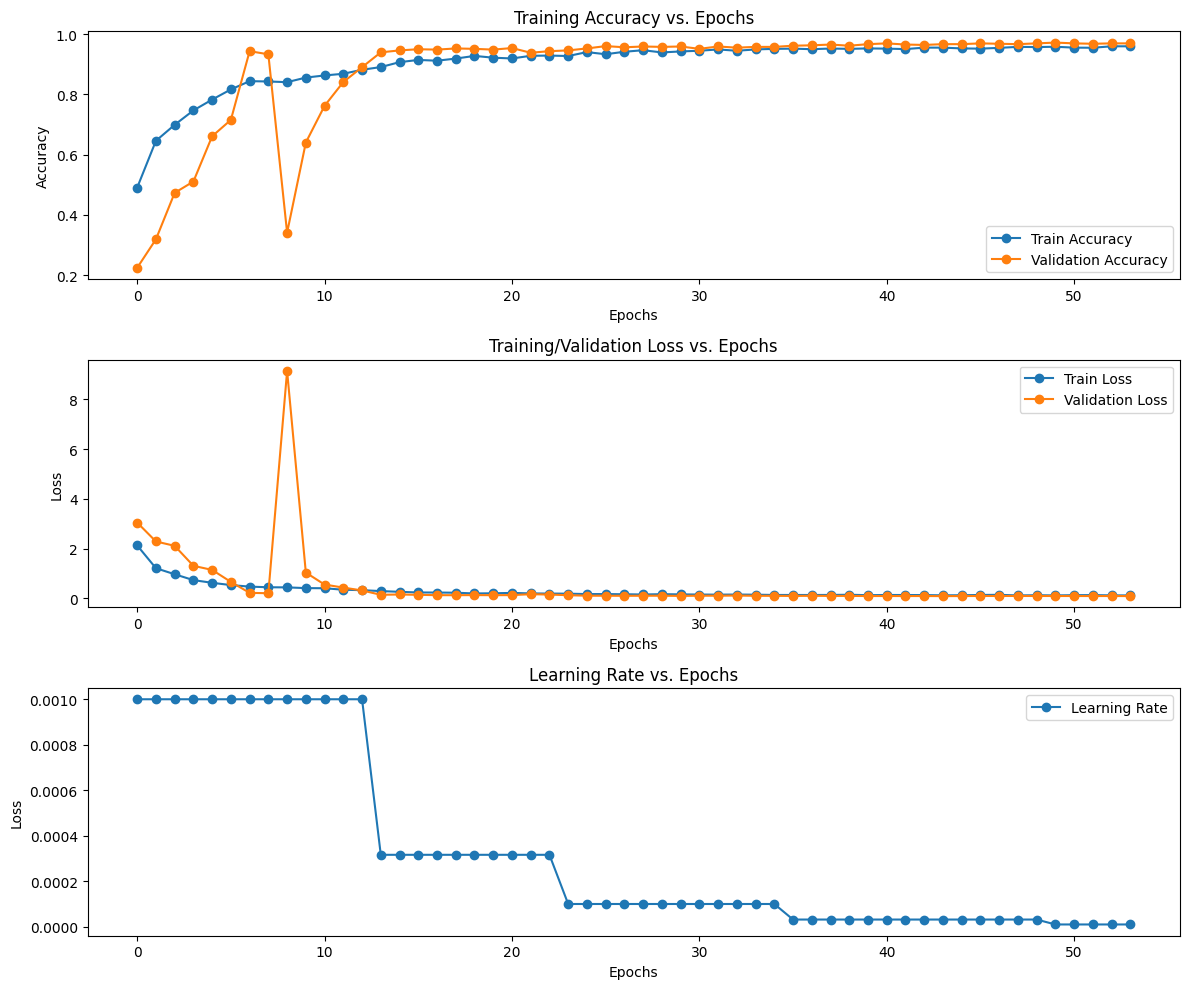

In [40]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [41]:
#Testing the Model on Test Set
test_dataset = r'C:\Users\USER\Documents\Kuliah\CompVis\test'

In [42]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 388 images belonging to 4 classes.


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step


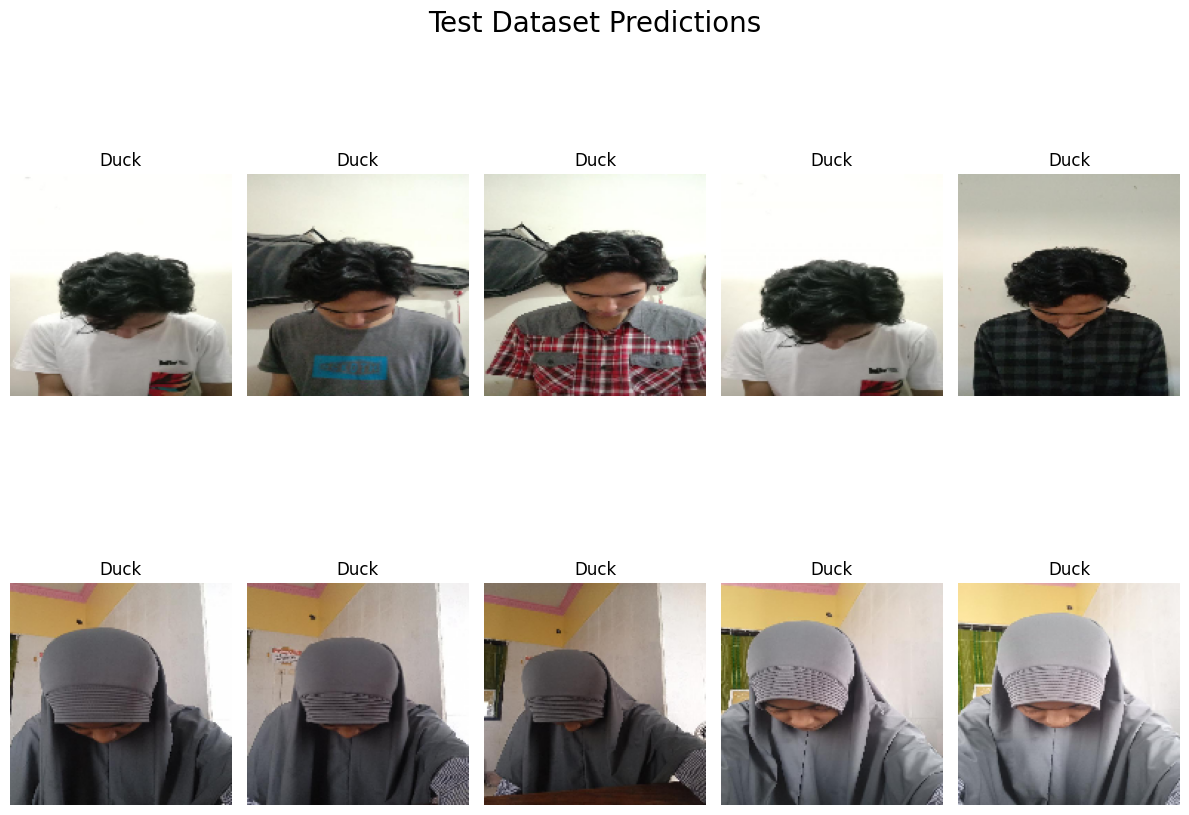

In [43]:
#Model Prediction on the Test Dataset
predictions = cnn_model.predict(test_generator)

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [44]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.9709 - loss: 0.1166


In [45]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.10023879259824753
Test Accuracy: 0.9716494679450989


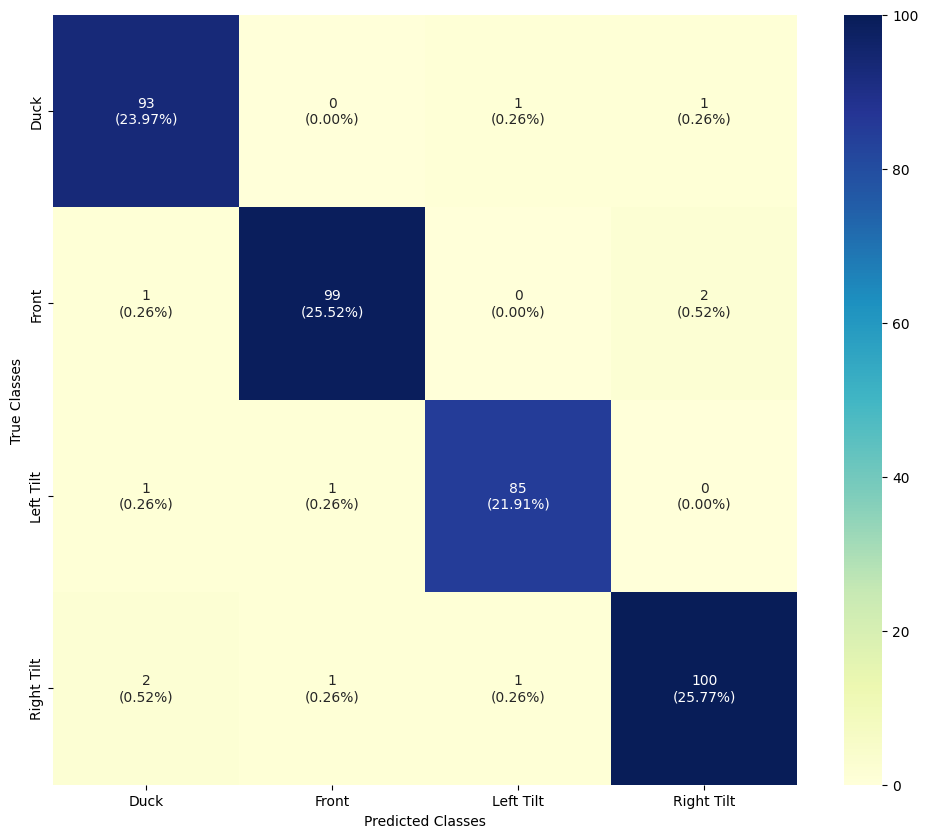

In [46]:
#Confusion Matrix
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(4, 4)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [65]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

        Duck       0.96      0.98      0.97        95
       Front       0.98      0.97      0.98       102
   Left Tilt       0.98      0.98      0.98        87
  Right Tilt       0.97      0.96      0.97       104

    accuracy                           0.97       388
   macro avg       0.97      0.97      0.97       388
weighted avg       0.97      0.97      0.97       388



In [68]:
from sklearn.metrics import average_precision_score

# Calculate Mean Average Precision (mAP)

# Convert y_true to one-hot encoding
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=len(labels))

# Calculate average precision for each class
average_precisions = []
for i in range(len(labels)):
    average_precisions.append(average_precision_score(y_true_one_hot[:, i], predictions[:, i]))

# Calculate mean average precision
mean_average_precision = np.mean(average_precisions)
print(f"Mean Average Precision (mAP): {mean_average_precision}")

Mean Average Precision (mAP): 0.996833892775532


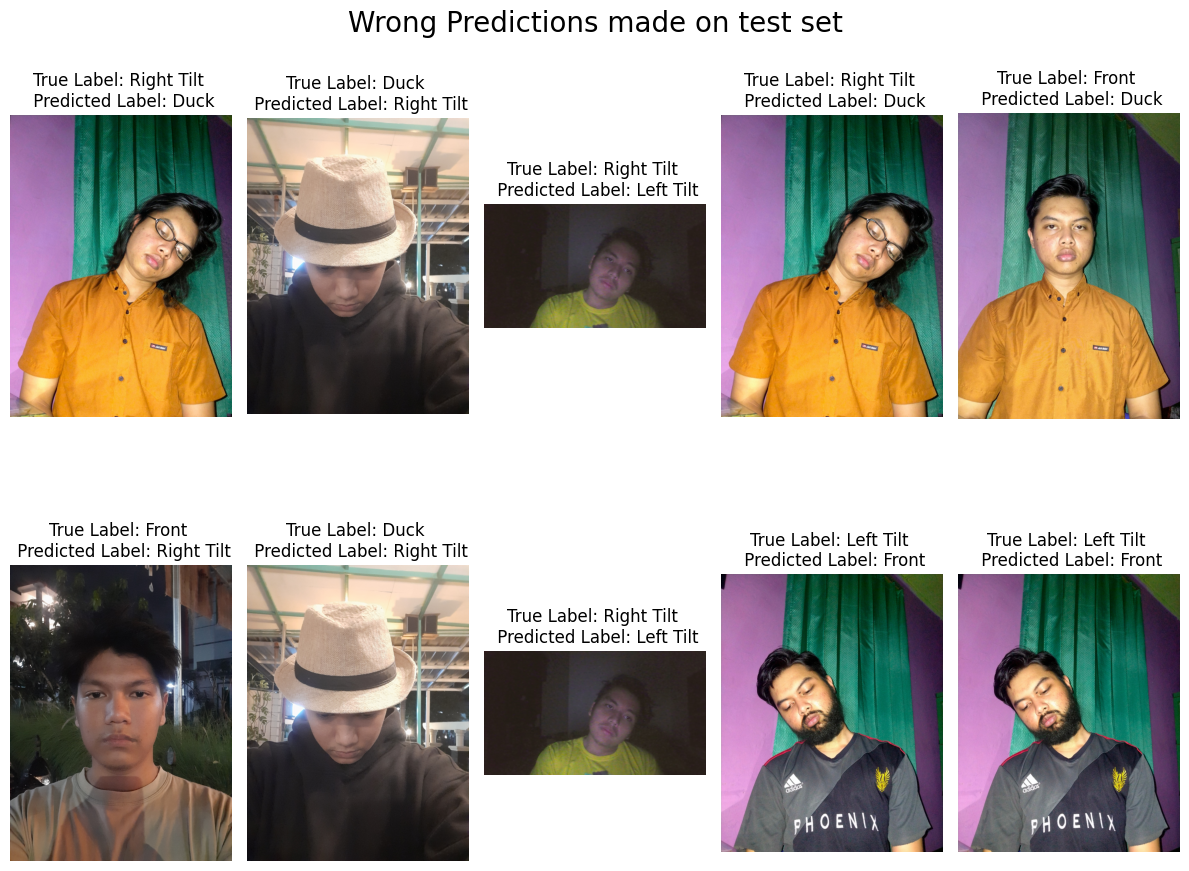

In [48]:
#Wrong Predictions
#  see where the model has given wrong predictions and what were the actual predictions on those images.
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()

In [49]:
# Export the model to your PC as a Keras file
model_save_path = r'C:\Users\USER\Documents\Kuliah\CompVis\Models\cnn_model_1_10_apply_earlyStop.keras'
cnn_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to C:\Users\USER\Documents\Kuliah\CompVis\Models\cnn_model_1_10_apply_earlyStop.keras


In [55]:
from tensorflow.keras.models import load_model

# Load the saved CNN model

current_cnn_model = load_model(r'C:\Users\USER\Documents\Kuliah\CompVis\Models\cnn_model_1_10_apply_earlyStop.keras')
print("Model loaded successfully.")

Model loaded successfully.


In [60]:
# Accessing the PC Camera and Making Predictions using CNN Model

# Initialize the video capture object
cap = cv2.VideoCapture(0)

# Check if the camera opened successfully
if not cap.isOpened():
    print("Error: Could not open video stream.")
else:
    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()
        
        if not ret:
            print("Error: Failed to capture image.")
            break
        
        # Preprocess the frame
        img = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
        img = img / 255.0  # Normalize the image
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        
        # Make predictions using the CNN model
        prediction = current_cnn_model.predict(img)
        predicted_label = labels[np.argmax(prediction)]
        
        # Display the resulting frame with the predicted label
        cv2.putText(frame, f"Prediction: {predicted_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.imshow('Camera', frame)
        
        # Break the loop on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Release the video capture object and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

In [59]:
# Capture a single frame from the PC camera and make a prediction using the CNN model

# Initialize the video capture object
cap = cv2.VideoCapture(0)

# Check if the camera opened successfully
if not cap.isOpened():
    print("Error: Could not open video stream.")
else:
    # Capture a single frame
    ret, frame = cap.read()
    
    if not ret:
        print("Error: Failed to capture image.")
    else:
        # Preprocess the frame
        img = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
        img = img / 255.0  # Normalize the image
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        
        # Make predictions using the CNN model
        prediction = cnn_model.predict(img)
        predicted_label = labels[np.argmax(prediction)]
        
        # Display the resulting frame with the predicted label
        cv2.putText(frame, f"Prediction: {predicted_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.imshow('Captured Image', frame)
        
        # Wait for a key press and close the window
        cv2.waitKey(0)
        cv2.destroyAllWindows()

# Release the video capture object
cap.release()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
